In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
import re

file = open('data/all_scripts.txt', 'r')
Lines = file.readlines()

speakers    = []
strings     = []
episodes    = []
scenes      = []
seasons     = []

data = pd.DataFrame(columns=["episode", "scene", "speaker", "line"])

# Strips the newline character
for line in Lines:
    line = line.strip()
    if re.search(r"^>> ", line)!= None:
        extracted = re.search(r"^>> Series (\d*).*", line)
        episode = extracted.group(0)[3:]
        season  = extracted.group(1)
    elif re.search(r"^> ", line)!= None:
        scene = re.search(r"^> (.*)", line).group(1)
    else:
        extracted = re.search(r"^(.*): (.*)", line)

        try: speaker = extracted.group(1)
        except: speaker = ""
        try: string = extracted.group(2)
        except: string = ""

        seasons.append(season)
        speakers.append(speaker)
        strings.append(string)
        episodes.append(episode)
        scenes.append(scene)

data = pd.DataFrame(np.array([seasons, episodes, scenes, speakers, strings]).T, columns=["season", "episode", "scene", "speaker", "line"])

file.close()
del Lines, speakers, strings, episodes, scenes, seasons

data.head(3)

,season,episode,scene,speaker,line
0,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."


In [3]:
pd.DataFrame(data[["season", "episode", "scene"]].drop_duplicates().groupby(by=["season"])["scene"].agg("count")).reset_index()

,season,scene
0,01,157
1,02,205
2,03,193
3,04,219
4,05,198
5,06,211
6,07,207
7,08,191
8,09,177
9,10,189


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [4]:
speaker_count = data[["speaker", "line"]].groupby(by="speaker").count().reset_index()
speaker_count.columns = ["speaker", "appearance_number"]
recurrent_characters = speaker_count[speaker_count["appearance_number"] >= 90]
recurrent_characters = recurrent_characters[recurrent_characters["speaker"] != "Man"]
recurrent_characters_list = recurrent_characters["speaker"].to_list()
recurrent_characters_list

['Amy',
 'Arthur',
 'Bernadette',
 'Bert',
 'Beverley',
 'Emily',
 'Howard',
 'Kripke',
 'Leonard',
 'Leslie',
 'Mrs Cooper',
 'Mrs Wolowitz',
 'Penny',
 'Priya',
 'Raj',
 'Sheldon',
 'Stuart',
 'Wil',
 'Zack']

In [5]:
data_recurrent = data[data["speaker"].isin(recurrent_characters_list)]
data_recurrent.head(3)

,season,episode,scene,speaker,line
0,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [6]:
%%capture
for character in EXCLUDE_CHARS:
    data_recurrent["line"] = data_recurrent["line"].str.replace(character, " ")
data_recurrent["line"] = data_recurrent["line"].str.lower()

In [7]:
data_recurrent.head(3)

,season,episode,scene,speaker,line
0,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...
1,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed what s your point
2,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,there s no point i just think it s a good ide...


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [27]:
corpus = " ".join(data_recurrent["line"].values)
corpus_df = pd.Series(np.array(corpus.split()))
corpus_count = corpus_df.value_counts().reset_index()
corpus_count.head(3)

,index,count
0,i,24718
1,you,22947
2,the,15041


<Axes: title={'center': 'Frequency histogram (loglog scale)'}, ylabel='Frequency'>

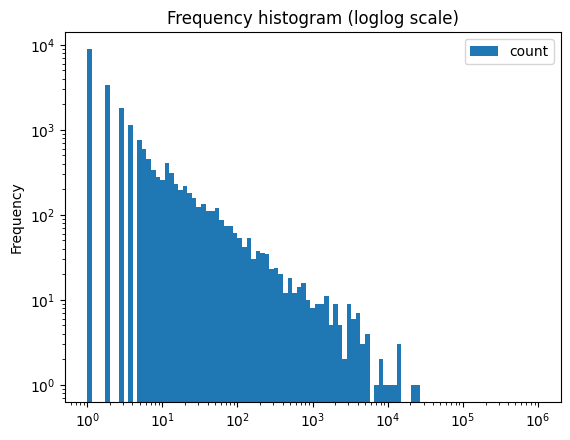

In [26]:
corpus_count.plot.hist(column="count", loglog=True, bins=np.logspace(0, 6, 100),
                           title="Frequency histogram (loglog scale)")

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [44]:
data_recurrent["speaker"].value_counts()

speaker
Sheldon         11657
Leonard          9815
Penny            7671
Howard           5871
Raj              4774
Amy              3470
Bernadette       2687
Stuart            732
Priya             222
Mrs Cooper        213
Emily             164
Beverley          162
Mrs Wolowitz      136
Zack              135
Arthur            130
Wil               126
Leslie            116
Kripke            106
Bert               95
Name: count, dtype: int64

In [180]:
%%capture
from tqdm import tqdm
tqdm.pandas()

def count_words(line):
    return len(line.split())

tmp = data_recurrent
tmp["word_count"] = tmp["line"].progress_apply(count_words)

In [181]:
tmp.head(3)

,season,episode,scene,speaker,line,word_count
0,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...,57
1,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed what s your point,5
2,01,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,there s no point i just think it s a good ide...,16


In [182]:
word_per_character = tmp[["speaker", "word_count"]].groupby("speaker").sum()
word_per_character = word_per_character.reset_index()
word_per_character.head(3)

,speaker,word_count
0,Amy,39874
1,Arthur,1451
2,Bernadette,27695


In [63]:
character = word_per_character[word_per_character["word_count"]==np.max(word_per_character["word_count"])]["speaker"].values[0]
print(f"Most talkative character: {character}")

Most talkative character: Sheldon


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [67]:
train_data  = data_recurrent[~data_recurrent["season"].isin(["10", "09"])]
test_data   = data_recurrent[data_recurrent["season"].isin(["10", "09"])]

In [68]:
train_data.head(3)

,season,episode,scene,speaker,line,word_count
40354,09,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Penny,so what package are you thinking,6
40355,09,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Leonard,mm this one comes with music and flowers oh ...,19
40356,09,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Penny,why would we want that,5


In [69]:
test_data.head(3)

,season,episode,scene,speaker,line,word_count
40354,09,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Penny,so what package are you thinking,6
40355,09,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Leonard,mm this one comes with music and flowers oh ...,19
40356,09,Series 09 Episode 01 – The Matrimonial Momentum,A Wedding Chapel.,Penny,why would we want that,5


In [70]:
train_data = train_data[["speaker", "line"]]
test_data = test_data[["speaker", "line"]]

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [110]:
def word_list(line):
    return set(line.split())

sheldon_lines = train_data[train_data["speaker"]=="Sheldon"]["line"]

words_sets = sheldon_lines.progress_apply(word_list)

sheldon_vocabulary = set()
for line_set in words_sets:
    sheldon_vocabulary = sheldon_vocabulary.union(line_set)

sheldon_vocabulary

100%|██████████| 9426/9426 [00:00<00:00, 171840.47it/s]


{'visualize',
 'dent',
 'secretary',
 'apparently',
 'mountain',
 'tubs',
 'infinite',
 'rainbow',
 'suspected',
 'mom',
 'raises',
 'bc',
 'graveyard',
 'unlocks',
 'schedule',
 'kansas',
 'salute',
 'witness',
 'love',
 'department',
 'exploder',
 'sloppy',
 'reserved',
 'anthropology',
 'swiss',
 'hop',
 'june',
 'bacterial',
 'regular',
 'understands',
 'sworn',
 'weekly',
 'unannounced',
 'heavenly',
 'explaining',
 'prospects',
 'grocery',
 'podium',
 'thistle',
 'evenly',
 'followed',
 'sleepy',
 'hurtful',
 'está',
 'interject',
 'hasn',
 'chopping',
 'luna',
 'halfway',
 'rest',
 'undertaking',
 'positively',
 'chemical',
 'receiving',
 'toolbox',
 'amazingly',
 'connect',
 'cleaning',
 'orange',
 'ecstatic',
 'mastery',
 'charming',
 'develops',
 'sonar',
 'amalgamation',
 '‘er',
 'bioorganic',
 'flecked',
 'disruption',
 'upbringing',
 'possum',
 'complacent',
 'jungles',
 'nightcrawler',
 'transverse',
 'licked',
 'united',
 'performing',
 'unfortunate',
 'adjective',
 'mis

In [111]:
others_lines = train_data[train_data["speaker"]!="Sheldon"]["line"]

words_sets = others_lines.progress_apply(word_list)

others_vocabulary = set()
for line_set in words_sets:
    others_vocabulary = others_vocabulary.union(line_set)

others_vocabulary

100%|██████████| 28697/28697 [00:00<00:00, 235811.22it/s]


{'dent',
 'drugged',
 'apparently',
 'mimosas',
 'mountain',
 'infinite',
 'mom',
 'raises',
 'bangs',
 'utensils',
 'martini',
 'betsy',
 'weirdos',
 'graveyard',
 'schedule',
 'abusing',
 'grisham',
 'kansas',
 'salute',
 'neurons',
 'witness',
 'enforce',
 'fixation',
 'love',
 'department',
 'josh',
 'swiss',
 'name”',
 'hop',
 'june',
 'bacterial',
 'regular',
 'duo',
 'understands',
 'algebraically',
 'weekly',
 'explaining',
 'prospects',
 'grocery',
 'repeal',
 'followed',
 'sleepy',
 'parked',
 'bubble…',
 'hasn',
 'halfway',
 'rest',
 'loosen',
 'chemical',
 'peyote',
 'receiving',
 'farewell',
 'attic',
 'flushed',
 'speeding',
 'connect',
 'orange',
 'cleaning',
 'biscuits',
 'charming',
 'sonar',
 'alleyway',
 'juy',
 'horrified',
 'abyss',
 'alcoa',
 'undesireable',
 'possum',
 'licked',
 'transverse',
 'united',
 'performing',
 'unfortunate',
 'aversion',
 'balling',
 '“you',
 'vishnu',
 'hurry',
 'madness',
 'outfits',
 'crouched',
 'sinuses',
 'considerably',
 'service

In [118]:
sheldon_exclusive_vocab = sheldon_vocabulary.difference(others_vocabulary)
sheldon_exclusive_vocab

{'visualize',
 'secretary',
 'rainbow',
 'tubs',
 'suspected',
 'unlocks',
 'bc',
 'exploder',
 'sloppy',
 'reserved',
 'anthropology',
 'sworn',
 'unannounced',
 'heavenly',
 'podium',
 'thistle',
 'evenly',
 'hurtful',
 'está',
 'interject',
 'luna',
 'chopping',
 'undertaking',
 'positively',
 'toolbox',
 'amazingly',
 'ecstatic',
 'mastery',
 'develops',
 'amalgamation',
 '‘er',
 'bioorganic',
 'flecked',
 'disruption',
 'upbringing',
 'complacent',
 'jungles',
 'nightcrawler',
 'adjective',
 'misspoke',
 'engorged',
 'regaled',
 'badala',
 '37b',
 'traveled',
 'commands',
 'mammal',
 'copious',
 'titans',
 'genius…',
 'cheaply',
 'promiscuous',
 'squabbling',
 'excess',
 'mistletoe',
 'absence',
 'discretion',
 'consumerism',
 'reprogrammed',
 'proofed',
 'zippers',
 'flaws',
 'atom…',
 'receive',
 'cluck',
 'endocrine',
 'corleone',
 'giveaway',
 'feast',
 'browser',
 'abundantly',
 'fortuitous',
 'repulse',
 'bested',
 'cyanide',
 'turing',
 'unfriend',
 'calloused',
 'shadows',

In [119]:
def is_it_sheldon(line, sheldon_exclusive_vocab):
    """Predicts whether a line is said by Sheldon or not"""
    return any(ele in sheldon_exclusive_vocab for ele in line.split())

In [131]:
train_data["is_it_sheldon"] = train_data["line"].progress_apply(lambda x: is_it_sheldon(x, sheldon_exclusive_vocab))
train_data.head(3)

 45%|████▍     | 17140/38123 [00:00<00:00, 163674.01it/s]

100%|██████████| 38123/38123 [00:00<00:00, 119827.38it/s]


,speaker,line,is_it_sheldon
0,Sheldon,so if a photon is directed through a plane wit...,True
1,Leonard,agreed what s your point,False
2,Sheldon,there s no point i just think it s a good ide...,False


In [174]:
# train accuracy & F1-score
TP = ((train_data["speaker"]=="Sheldon")*(train_data["is_it_sheldon"]==True).astype(int)).sum()
TN = ((train_data["speaker"]!="Sheldon")*(train_data["is_it_sheldon"]==False).astype(int)).sum()
FP = ((train_data["speaker"]!="Sheldon")*(train_data["is_it_sheldon"]==True).astype(int)).sum()
FN = ((train_data["speaker"]=="Sheldon")*(train_data["is_it_sheldon"]==False).astype(int)).sum()

accuracy        = (TP + TN)/(train_data.shape[0])
training_fscore = TP/(TP + 0.5*(FP + FN))

print("Training data:")
print("--------------")
print(f"accuracy: {accuracy:0.2f}")
print(f"F1-score: {training_fscore:0.2f}")

Training data:
--------------
accuracy: 0.84
F1-score: 0.54


In [177]:
test_data["is_it_sheldon"] = test_data["line"].progress_apply(lambda x: is_it_sheldon(x, sheldon_exclusive_vocab))
test_data.head(3)

100%|██████████| 10159/10159 [00:00<00:00, 261187.91it/s]


,speaker,line,is_it_sheldon
40354,Penny,so what package are you thinking,False
40355,Leonard,mm this one comes with music and flowers oh ...,False
40356,Penny,why would we want that,False


In [179]:
# test accuracy & F1-score
TP = ((test_data["speaker"]=="Sheldon")*(test_data["is_it_sheldon"]==True).astype(int)).sum()
TN = ((test_data["speaker"]!="Sheldon")*(test_data["is_it_sheldon"]==False).astype(int)).sum()
FP = ((test_data["speaker"]!="Sheldon")*(test_data["is_it_sheldon"]==True).astype(int)).sum()
FN = ((test_data["speaker"]=="Sheldon")*(test_data["is_it_sheldon"]==False).astype(int)).sum()

accuracy        = (TP + TN)/(test_data.shape[0])
training_fscore = TP/(TP + 0.5*(FP + FN))

print("Test data:")
print("--------------")
print(f"accuracy: {accuracy:0.2f}")
print(f"F1-score: {training_fscore:0.2f}")

Test data:
--------------
accuracy: 0.77
F1-score: 0.22


Our method is to check whether a line contains one of the words Sheldon has been the only one to use in the training set. We see that we are able to get to an accuracy of 0.77!